# Determining Properties of Galaxies Using Machine Learning

---
## Jorge Bermeo, Nathanael Gutierrez, Tokhirjon Malikov

## Table of Contents
1. [Summary](#abstract)
1. [Learning Set](#learning-set)
1. [Predictions](#predictions)
    1. [Predicting age](#PREDICTING-AGE)
    1. [Predicting tau](#predicting-tau)
    1. [Predicting mass](#PREDICTING-MASS)
    1. [Predicting dust](#predicting-dust)
1. [Adding Noise](#adding-noise)
    1. [Age](#age-noise)
    1. [Tau](#tau-noise)
    1. [Mass](#mass-noise)
    1. [Dust](#dust-noise)
1. [References](#references)

---
## SUMMARY

SUMMARY GOES HERE

---

## LEARNING SET

SHORT DESCRIPTION OF OUR LEARNING SET GOES HERE

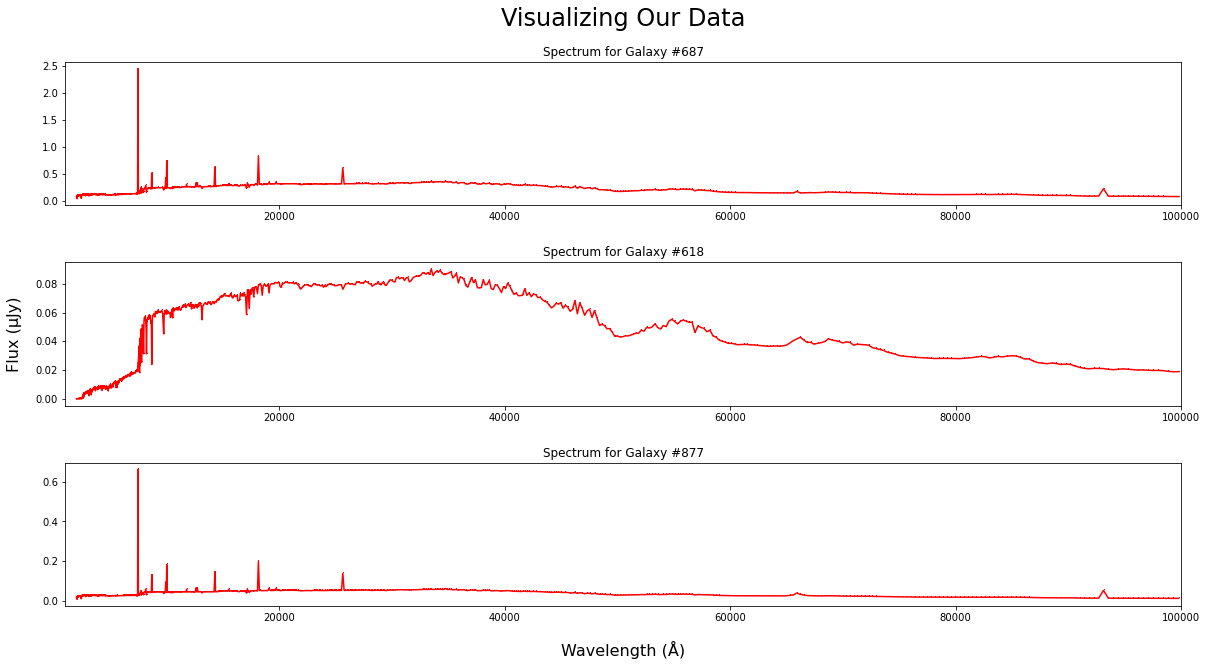

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

spectra = pd.read_csv('spectra.dat', delimiter=' ', header=None)
wavelengths = pd.read_csv('wavelengths.csv', header=None)
galaxy_properties = pd.read_csv('galaxy_properties.csv', index_col = 0)

random.seed(1010) # for reproducibility
rows = [random.randint(0, len(spectra)) for i in range(3)]  # select three random galaxy spectrums to visualize

plt.rcParams["figure.figsize"] = (20,10) #set size of plot

fig = plt.figure()
ax = fig.add_subplot(111) # Generating subplots for our figure; see https://stackoverflow.com/a/6981055/3135556
ax1 = fig.add_subplot(311) # 3 rows, 1 column, plot at position 1
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(wavelengths, spectra.loc[rows[0]], 'r,-')
ax2.plot(wavelengths, spectra.loc[rows[1]], 'r,-')
ax3.plot(wavelengths, spectra.loc[rows[2]], 'r,-')

ax1.set_xlim(1000, 100000) # restrict the x-axis to mitigate the gap that exists around x=0
ax2.set_xlim(1000, 100000)
ax3.set_xlim(1000, 100000)

# Set common labels
ax.set_xlabel("Wavelength (Å)", fontsize=16, labelpad=18)
ax.set_ylabel("Flux (μJy)", fontsize=16, labelpad=20)
ax.set_title("Visualizing Our Data", fontsize=24, pad=36)

ax1.set_title("Spectrum for Galaxy #" + str(rows[0]))
ax2.set_title("Spectrum for Galaxy #" + str(rows[1]))
ax3.set_title("Spectrum for Galaxy #" + str(rows[2]))

plt.subplots_adjust(hspace=0.4) # increase vertical distance between subplots

## PREDICTING AGE

SHORT BLURB GOES HERE

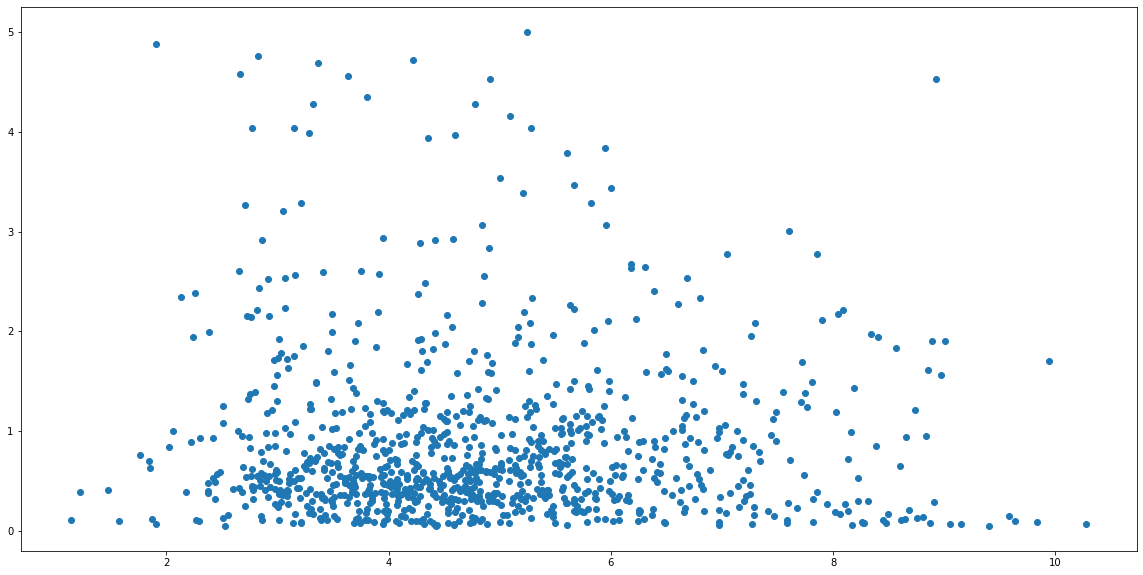

In [3]:
# TODO: ADD LABELS, TITLES TO GRAPH

ages = galaxy_properties['age']
X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plt.scatter(X, ages)

0.6926516982368061
0.21846968663353358


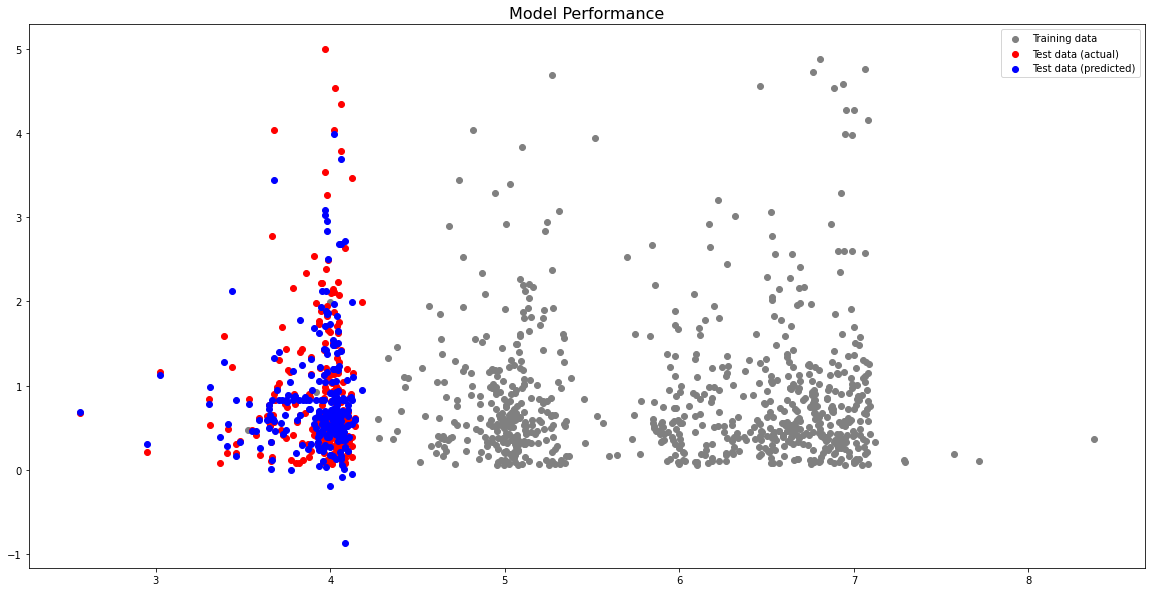

In [7]:
# TODO: LABEL GRAPH AND BEAUTIFY
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(spectra, ages, random_state=101)
model = SVR(C=2300, gamma=0.08, kernel='rbf')
model.fit(X_train, y_train)
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))

X = np.empty(len(X_train))
for i in range(len(X_train)):
    X[i] = np.log(np.sum(X_train[i]))
    
X2 = np.empty(len(X_test))
for i in range(len(X_test)):
    X2[i] = np.log(np.sum(X_test[i]))

fig, ax = plt.subplots()
ax.scatter(X, y_train, color='gray', label='Training data')
ax.scatter(X2, y_test, color='red', label='Test data (actual)')
ax.scatter(X2, model.predict(X_test), color='blue', label='Test data (predicted)')
ax.legend()
ax.set_title("Model Performance", fontsize=16)
plt.show()
fig.savefig("model_perfomance", dpi=300)

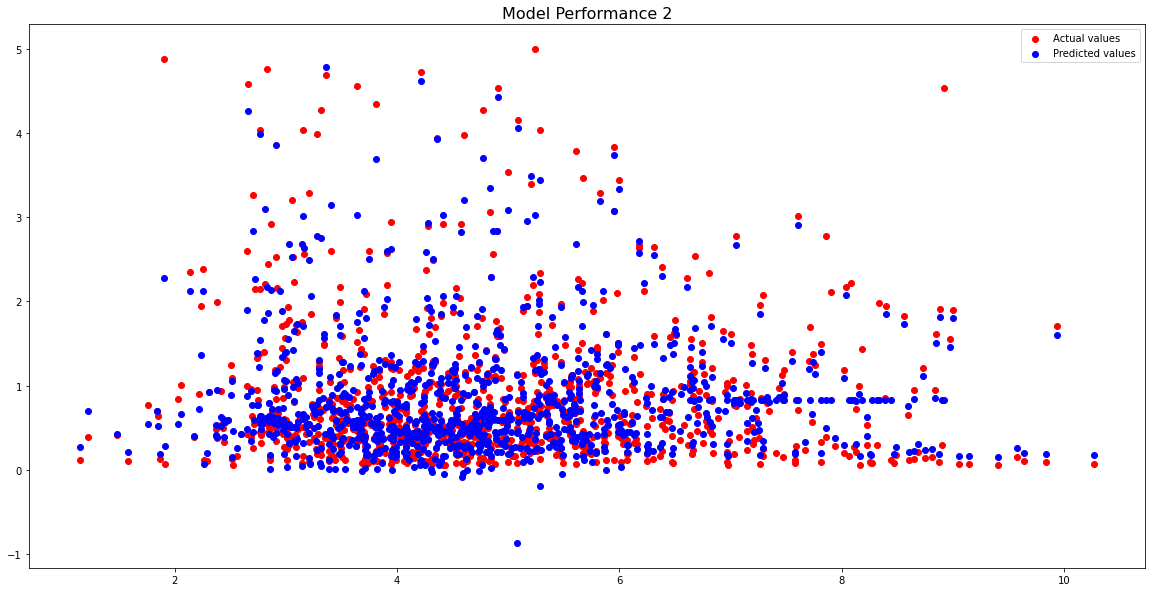

In [8]:
# TODO: LABEL GRAPH AND BEAUTIFY
# TODO: 

X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

fig, ax = plt.subplots()
ax.scatter(X, ages, color='red', label='Actual values')
plt.scatter(X, model.predict(spectra), color='blue', label='Predicted values')
ax.legend()
ax.set_title("Model Performance 2", fontsize=16)
fig.savefig("model_perfomance2", dpi=300)

## PREDICTING MASS

SHORT BLURB GOES HERE

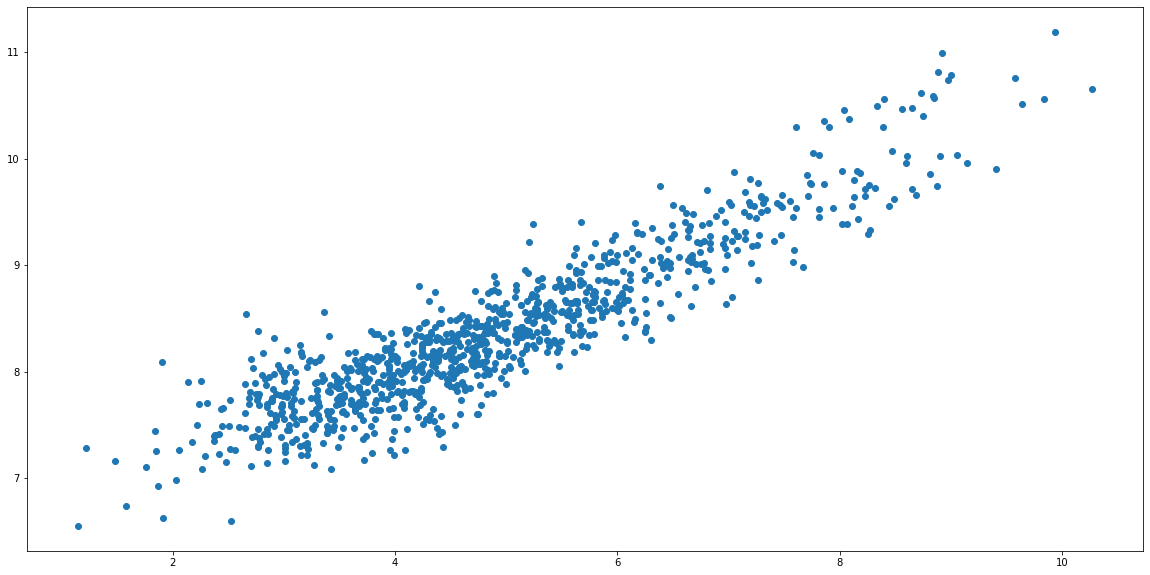

In [10]:
# TODO: LABEL GRAPH
mass = galaxy_properties['mass']

X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plt.scatter(X, mass)

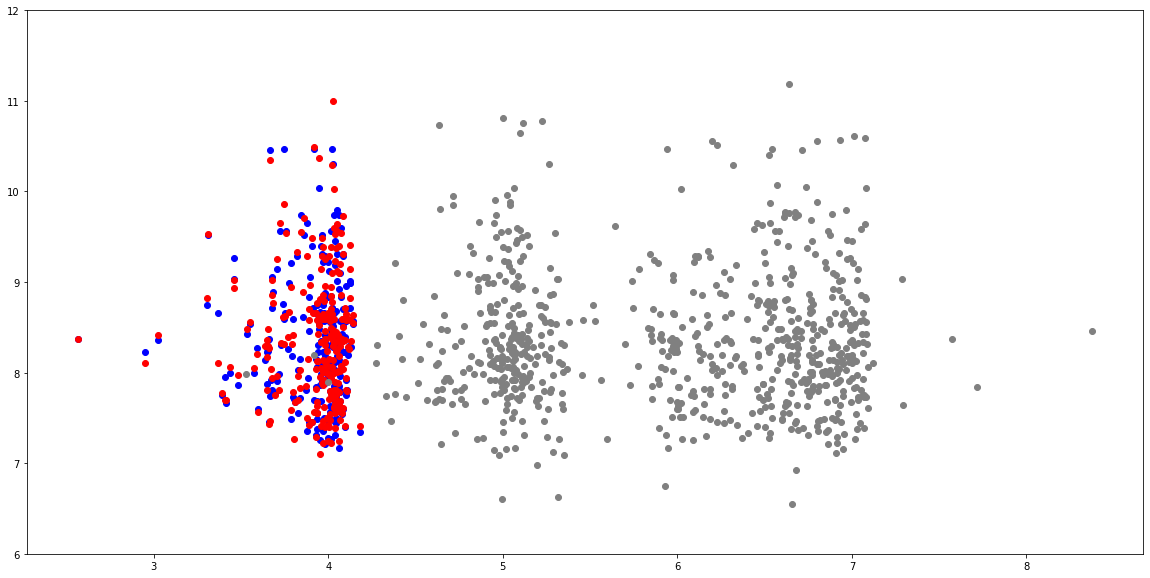

In [14]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(spectra, mass, random_state = 101)
model = DecisionTreeRegressor(max_features=803)
model.fit(X_train, y_train)

prediction = model.predict(X_test)

X = np.empty(len(X_test))
X2 = np.empty(len(X_train))

for i in range(len(X_test)):
    X[i] = np.log(np.sum(X_test[i]))
    
for i in range(len(X_train)):
    X2[i] = np.log(np.sum(X_train[i]))

plt.ylim(6, 12)
plt.scatter(X, prediction, c='blue')
plt.scatter(X, y_test, c='red')
plt.scatter(X2, y_train, c='grey')

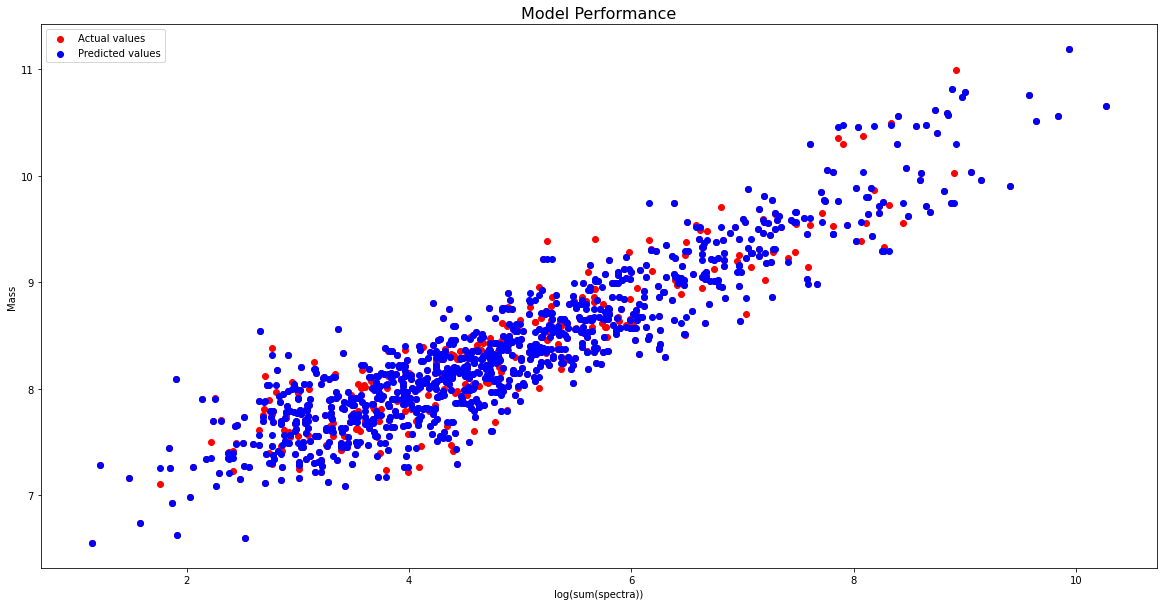

In [17]:
X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

fig, ax = plt.subplots()
ax.scatter(X, mass, color='red', label='Actual values')
plt.scatter(X, model.predict(spectra), color='blue', label='Predicted values')
ax.legend()
ax.set_title("Model Performance", fontsize=16)
ax.set_ylabel("Mass")
ax.set_xlabel("log(sum(spectra))")
fig.savefig("model_performance mass", dpi=300)

## ADDING NOISE

In [19]:
def add_noise(df, percent):
    """
    Add a percetange of noise to a Pandas DataFrame.
    Returns a new Pandas DataFrame containing the noise.
    
    Positional arguments:
    - df : a Pandas DataFrame
    - percent: percentage of noise desired, as a float. 
               For example, a value of 0.10 is 10%. 
               Similarly a value of 1.15 is 115%. 
    """
    ndf = pd.DataFrame()
    for i in range(len(df.columns)):
        mean = df[i] * percent
        gauss_dist = scipy.stats.norm.rvs(loc=mean, scale=0.000001, size=1000)
        ndf[i] = df[i] + gauss_dist
        
    return ndf